In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
                'image/height': tf.FixedLenFeature([], tf.int64),
                'image/width': tf.FixedLenFeature([], tf.int64),
                'image/depth': tf.FixedLenFeature([], tf.int64),
                'label': tf.FixedLenFeature([], tf.int64),
                'image/raw': tf.VarLenFeature(tf.string)})

    # Shape elements must beint32 tensors!
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)
    depth = tf.cast(features['image/depth'], tf.int32)

    image = tf.decode_raw(features['image/raw'].values, tf.uint8)
    im_shape = tf.pack([height, width, depth])
    image = tf.reshape(image, [256, 256, 3])
    # We need some operation subsequent to reshape, so that the 
    # tensor acquires a shape. This is necessary for `shuffle_batch`
    tf.random_crop(image, [height, width, depth])
    # Convert from [0, 255] -> [-0.5, 0.5] floats.
    image = tf.cast(image, tf.float32) * (1. / 255)
    #image = tf.cast(image, tf.float32) * (1. / 255) - 0.5

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)
#     return {'image/raw': features['image/raw'], 
#             'image/height': features['image/height'],
#             'image/width': features['image/width'], 
#             'image/depth': features['image/depth']}
    return image, label

In [4]:
image, label = read_and_decode('../data/cells_train.tfrecords')

In [5]:
image.get_shape()

TensorShape([Dimension(256), Dimension(256), Dimension(3)])

In [6]:
sess = tf.Session()
init = tf.global_variables_initializer()
tf.train.start_queue_runners(sess=sess)
im_1, lab_1 = sess.run([image, label])

In [7]:
im_1.shape

(256, 256, 3)

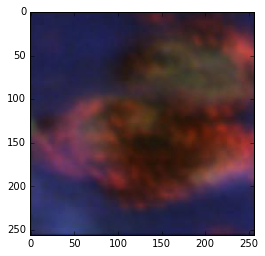

In [8]:
plt.imshow(im_1)

In [9]:
sess = tf.Session()
init = tf.global_variables_initializer()
tf.train.start_queue_runners(sess=sess)

label_val_1, image_val_1 = sess.run([image, label])
# second example from file
label_val_2, image_val_2 = sess.run([image, label])

In [10]:
# get single examples
image, label = read_and_decode("../data/cells_train.tfrecords")

# The following groups the examples into batches randomly
images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=40,
    capacity=400,
    min_after_dequeue=200)


# The model: y_pred = Wx + b
W = tf.Variable(tf.zeros([256 * 256 * 3, 3]))
b = tf.Variable(tf.zeros([3]))

y_pred = tf.matmul(tf.reshape(images_batch, [-1, 256 * 256 * 3]), W) + b
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, labels_batch)

# We can use this for monitoring:
loss_mean = tf.reduce_mean(loss)

train_op = tf.train.AdamOptimizer().minimize(loss)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

n_iterations = 100
losses = []
#with tf.name_scope('train'):
for ii in range(n_iterations):
    # pass it in through the feed_dict
    _, loss_val = sess.run([train_op, loss_mean])
    losses.append(loss_val)
#merged = tf.summary.merge_all()
#train_writer = tf.summary.FileWriter(op.join('.', 'train'), sess.graph)

In [11]:
train_op

In [12]:
y_pred = tf.matmul(tf.reshape(images_batch, [-1,  256 * 256 * 3]), W) 

In [13]:
np.mean(sess.run(tf.equal(tf.cast(tf.argmax(y_pred, 1), tf.int32), labels_batch)))

0.625

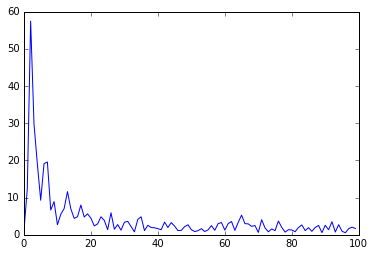

In [14]:
plt.plot(losses)

In [24]:
image, label = read_and_decode("../data/cells_train.tfrecords")
this_image = tf.placeholder("float", shape=[256, 256, 3])
this_label = tf.placeholder("int32", shape=[])
y_pred = tf.matmul(tf.reshape(this_image, [-1, 256*256*3]), W) + b
correct_prediction = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(y_pred, 1), tf.int32), this_label), tf.int8))
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)
p = []
for ii in range(200):
    im, la = sess.run([image, label])
    p.append(sess.run(correct_prediction, feed_dict={this_image:im, this_label:la}))

In [29]:
y_pred.eval(session=sess)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_12' with dtype float and shape [256,256,3]
	 [[Node: Placeholder_12 = Placeholder[dtype=DT_FLOAT, shape=[256,256,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_12', defined at:
  File "/Users/arokem/anaconda/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/arokem/anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-69896ed2889e>", line 2, in <module>
    this_image = tf.placeholder("float", shape=[256, 256, 3])
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/arokem/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_12' with dtype float and shape [256,256,3]
	 [[Node: Placeholder_12 = Placeholder[dtype=DT_FLOAT, shape=[256,256,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
